In [43]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('../..', 'src')))
sys.setrecursionlimit(20500)
import pandas as pd
import spacy

import matplotlib.pyplot as plt
import clean_dataset as clean
import make_dataset as mk
import vectorize_embed as em
import tools as tools

import pickle
import numpy as np

'''features'''
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.pipeline import Pipeline

'''Metrics/Evaluation'''
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline


import seaborn as sns

In [44]:
'''import data'''

df = pd.read_json(os.path.abspath(os.path.join('../..', 'data/processed/encoded_labels'))+'/main_strategies_all.json')  
'''lowercase data and str type data'''
df['all_text_clean_spacy'] = df['all_text_clean_spacy'].astype(str).apply(clean.basic)
df['all_text_clean'] = df['all_text_clean'].astype(str)

df.shape

(600, 17)

In [46]:
for index, row in df.iterrows():
    
    if type(row['PIMS_ID']) != float:
        print(index)

In [47]:
df_trunc = mk.truncate(df, 500, save=True)

In [48]:
df.columns

Index(['PIMS_ID', 'all_text_clean', 'all_text_clean_spacy',
       'capacity_building', 'enabling', 'finance_economy',
       'food_and_agricultural_commodities', 'governance', 'law_regulation',
       'management_operation', 'mitigation_adaptation', 'monitor_inventory',
       'technology_innovation', 'category_1', 'category_2', 'category_3',
       'labels'],
      dtype='object')

## How to evaluate results:
* Accuracy is a great measure but only when you have symmetric datasets (false negatives & false positives counts are close), also, false negatives & false positives have similar costs.

* If the cost of false positives and false negatives are different then F1 is your savior. F1 is best if you have an uneven class distribution.

* Precision is how sure you are of your true positives whilst recall is how sure you are that you are not missing any positives.

* Choose Recall if the idea of false positives is far better than false negatives, in other words, if the occurrence of false negatives is unaccepted/intolerable, that you’d rather get some extra false positives(false alarms) over saving some false negatives, like in our diabetes example. You’d rather get some healthy people labeled diabetic over leaving a diabetic person labeled healthy.

* Choose precision if you want to be more confident of your true positives. for example, Spam emails. You’d rather have some spam emails in your inbox rather than some regular emails in your spam box. So, the email company wants to be extra sure that email Y is spam before they put it in the spam box and you never get to see it.

* Choose Specificity if you want to cover all true negatives, meaning you don’t want any false alarms, you don’t want any false positives. for example, you’re running a drug test in which all people who test positive will immediately go to jail, you don’t want anyone drug-free going to jail. False positives here are intolerable.

## We merge strategy 1, 2 and 3 together and "artificially" produces more example per category. Then we train a one-vs-rest classifier for each category independantly. In a perfect model word we could run the 10 models over unseen data and ideally tag up to 3 correct categories.

### Oumaima's implementation:

In [21]:
#Holding out 5 rows from the original dataframe for prediction at the end
df_holdout = df_trunc.iloc[:5]

df_trunc = df_trunc.iloc[5:]
df_holdout

,PIMS_ID,all_text_clean,all_text_clean_spacy,capacity_building,enabling,finance_economy,food_and_agricultural_commodities,governance,law_regulation,management_operation,mitigation_adaptation,monitor_inventory,technology_innovation,category_1,category_2,category_3,labels
5,2284.0,the egyptian government is a strong proponent ...,egyptian government strong proponent renewable...,1,0,1,1,0,0,0,0,0,0,food_and_agricultural_commodities,finance_economy,capacity_building,"[1, 0, 1, 1, 0, 0, 0, 0, 0, 0]"
7,2596.0,the overall objective of the project is to red...,overall objective project reduce environmental...,1,0,0,0,0,0,1,0,0,1,technology_innovation,management_operation,capacity_building,"[1, 0, 0, 0, 0, 0, 1, 0, 0, 1]"
8,2762.0,madagascar is recognized as one of the greates...,madagascar recognize great mega diversity hots...,0,0,0,1,0,0,1,0,1,0,management_operation,food_and_agricultural_commodities,monitor_inventory,"[0, 0, 0, 1, 0, 0, 1, 0, 1, 0]"
9,2890.0,the binational artibonite river basin has suff...,binational artibonite river basin suffer accel...,0,1,0,0,1,0,1,0,0,0,governance,management_operation,enabling,"[0, 1, 0, 0, 1, 0, 1, 0, 0, 0]"
10,3066.0,this project will address land degradation ld ...,project address land degradation ld state serg...,0,0,0,0,1,1,1,0,0,0,governance,law_regulation,management_operation,"[0, 0, 0, 0, 1, 1, 1, 0, 0, 0]"


In [25]:
#Creating the features (tf-idf weights) for the processed text
texts = df_trunc['all_text_clean'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts)
   

#LE = LabelEncoder()
#df_trunc['label_num'] = LE.fit_transform(df_trunc['capacity_building'])

y = df_trunc['food_and_agricultural_commodities'].values

#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)

In [26]:
#Preliminary model evaluation using default parameters

#Creating a dict of the models
model_dict = {'Dummy' : DummyClassifier(random_state=3),
              'Logistic weighted Regression' : LogisticRegression(class_weight = "balanced"),
              'Stochastic Gradient Descent' : SGDClassifier(random_state=3, loss='log'),
              'Stochastic Gradient Descent balanceed' : SGDClassifier(random_state=3, loss='log',class_weight = "balanced" ),
              'Random Forest': RandomForestClassifier(random_state=3),
              'Decsision Tree': DecisionTreeClassifier(random_state=3),
              'AdaBoost': AdaBoostClassifier(random_state=3),
              'Gaussian Naive Bayes': GaussianNB(),
              'K Nearest Neighbor': KNeighborsClassifier()}

#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)

#Function to get the scores for each model in a df
def model_score_df(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

model_score_df(model_dict)

C:\Users\Jonas\Anaconda3\envs\nce_1\lib\site-packages\sklearn\dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


,model_name,accuracy_score,precision_score,recall_score,f1_score
1,Logistic weighted Regression,0.847561,0.670857,0.719444,0.689559
7,Gaussian Naive Bayes,0.79878,0.638667,0.734722,0.659001
6,AdaBoost,0.884146,0.729391,0.611111,0.640641
2,Stochastic Gradient Descent,0.896341,0.849686,0.596528,0.631947
3,Stochastic Gradient Descent balanceed,0.786585,0.604097,0.663194,0.617716
5,Decsision Tree,0.810976,0.580789,0.590972,0.585149
8,K Nearest Neighbor,0.878049,0.696203,0.564583,0.582272
4,Random Forest,0.884146,0.777433,0.546528,0.555809
0,Dummy,0.79878,0.520327,0.519444,0.51983


## Hpyereparameter Tuning:


In [ ]:
#Gridsearch with 5-fold cross validation
#Warning this can take a long time!!!

#Logistic
loss =  ['log']
penalty = ['l2','l1']
alpha = [1e-6, 1e-3, 1e-1, 1e0]
max_iter = [100, 1000, 10000]
tol = [None, 1e-3]
eta0 = [0.1, 0.001]
c = np.logspace(-4, 4, 20)
solver =  ['liblinear ','lbfgs']

random_state = [3]

clf = LogisticRegression()

params = dict(#loss=loss,
              penalty=penalty,
              #alpha=alpha,
              max_iter=max_iter,
              tol=tol,
              random_state=random_state,
              C = c,
              solver = solver)

gridsearch = GridSearchCV(clf,
                          params,
                          cv = 5,
                          verbose = 1, 
                          n_jobs = -1)

sgd_best_model = gridsearch.fit(X, y)
print (gridsearch.best_params_)

In [ ]:
#SDG
loss =  ['log']
penalty = ['l2','l1']
alpha = [1e-6, 1e-3, 1e-1, 1e0]
max_iter = [100, 1000, 10000]
tol = [None, 1e-3]
eta0 = [0.1, 0.001]
c = np.logspace(-4, 4, 20)
solver =  ['liblinear ','lbfgs']

random_state = [3]

clf = SGDClassifier()

params = dict(loss=loss,
              penalty=penalty,
              alpha=alpha,
              max_iter=max_iter,
              tol=tol)

gridsearch = GridSearchCV(clf,
                          params,
                          cv = 5,
                          verbose = 1, 
                          n_jobs = -1)

sgd_best_model = gridsearch.fit(X, y)
print (gridsearch.best_params_)

In [ ]:
sgd_best_model = SGDClassifier(alpha = 0.001,
             loss = 'log',
             max_iter = 100,
             penalty = 'l2',
             tol = 0.001)

## Prediction on unseen data using best clf

In [ ]:
#Get the text of the 5 articles we held out from each of the categories in the beginning
unseen = df_holdout['all_text_clean_spacy'].astype('str') 

#Use the saved models to transform the unseen text with tf-idf and lsa
X_unseen_tfidf = tfidf_vectorizer.transform(unseen) 
X_unseen = lsa.transform(X_unseen_tfidf)

#Fit the models with the best params on the full data
clf.fit(X, y)

#Make the prediction on the unseen articles with the fitted best models and put it into a df alongside the correct labels
df_holdout['prediction'] = clf.predict(X_unseen)

label_num_dict = {1: 1,
                  0: 0}

df_holdout['correct'] = df_holdout['food_and_agricultural_commodities'].map(label_num_dict)
df_holdout_2 = pd.DataFrame(df_holdout, columns = ['all_text_clean', 'food_and_agricultural_commodities', 'prediction'])

df_holdout_2

## Logistic Regression Grid Search:

In [12]:
def binary_log_classifier(dataframe, category):
    X_train, X_test, y_train, y_test = train_test_split(dataframe['all_text_clean_spacy'],
                                                        dataframe[category].values,
                                                        test_size = .3,
                                                        random_state = 1,
                                                        shuffle = True)
    print('training size:', len(X_train))
    print('test size:', len(X_test))
    print('distribution of tagged projects:', dataframe[category].value_counts())
    #if weighted == True:
        #class_weights = tools.get_class_weights(y_train)
        #print(class_weights)
    #else: 
        #class_weights = None
        

    '''extract features using tfidf vecorization:'''
    vectorizer = TfidfVectorizer(ngram_range = (1,2), min_df = 0.01, max_df = 0.95)
    vect = vectorizer.fit(X_train)
    X_train = vect.transform(X_train)
    X_test = vect.transform(X_test)
    
    "feature reduction"
    #lsa = TruncatedSVD(n_components=100, 
                   #n_iter=10, 
                   #random_state=3)

    #X_train = lsa.fit_transform(X_train)
    #X_test = lsa.fit_transform(X_test)    
    
    
    # set pipeline
    pipe = Pipeline([('classifier' , LogisticRegression())])

    # Create param grid.
    param_grid = [
        {'classifier' : [LogisticRegression(class_weight = "balanced")],
         'classifier__penalty' : ['l1', 'l2'],
        'classifier__C' : np.logspace(-4, 4, 20),
        'classifier__solver' : ['liblinear ','lbfgs']}
    ]

    # Create grid search object
    clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring = 'accuracy')

    # Fit on data
    best_clf = clf.fit(X_train, y_train)
    print('')
    print('Training accuracy:', best_clf.score(X_train, y_train).round(3))
    print('Test accuracy:', best_clf.score(X_test, y_test).round(3))
    y_hat = best_clf.predict(X_test)
    print('recall', recall_score(y_test, y_hat))

    from sklearn.metrics import classification_report
    print(classification_report(y_test, y_hat))    
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
    specificity = tn / (tn+fp)
    print('specificity is:', specificity)

    return best_clf, vectorizer, y_train

In [13]:
best_clf, vectorizer, y_train = binary_log_classifier(df_trunc, 'food_and_agricultural_commodities')

# precision 0.33 on class 1: 33% of all items predicted as 1 are truly 1.
# recall 0.6 on class 1: 60% of all true 1 are predicted as 1. 

training size: 385
test size: 165
distribution of tagged projects: 0    481
1     69
Name: food_and_agricultural_commodities, dtype: int64
Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s



Training accuracy: 1.0
Test accuracy: 0.879
recall 0.15789473684210525
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       146
           1       0.43      0.16      0.23        19

    accuracy                           0.88       165
   macro avg       0.66      0.57      0.58       165
weighted avg       0.84      0.88      0.85       165

specificity is: 0.9726027397260274


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    3.9s finished


In [ ]:
'''Test unseen data:'''

def infer_data():
    
    input_string =  input("Enter your text: ") 
    test = [input_string]

    
    #transform data
    test = pd.DataFrame(test, columns =['input_text'])
    test['text'] = test['input_text'].apply(clean.basic)
    cleaned = pd.Series(test['text'])
    vector = vectorizer.transform(cleaned)
    
    y_hat = best_clf.predict(vector)
    y_prob = best_clf.predict_proba(vector)
    print(y_prob)   
    print(y_hat)
    return y_hat, y_prob

In [ ]:
prediction, probability = infer_data()

## Let's build a mulit-class model for the first main strategy and see how it works:

In [53]:
#drop columns with tiny sample sizes
df= df.drop(columns=['mitigation_adaptation'])
def get_label(row):
    for c in df.columns:
       if row[c]==1:
            return c
        
df['category_1'] = df.apply(get_label, axis=1)
df.category_1 = pd.Categorical(df.category_1)
df['cat'] = df.category_1.cat.codes


df_lambda = df.groupby('category_1', as_index = False).agg({'PIMS_ID':'count'})
df_lambda.rename({'PIMS_ID':'Count'}, axis = 1, inplace = True)
print(f'Shape:{df_lambda.shape}')
display(df_lambda)


Shape:(8, 2)


,category_1,Count
0,capacity_building,367
1,enabling,73
2,finance_economy,57
3,food_and_agricultural_commodities,17
4,governance,61
5,law_regulation,16
6,management_operation,7
7,monitor_inventory,1


In [55]:
X_train, X_test, y_train, y_test = train_test_split(df['all_text_clean_spacy'],
                                                    df['category_1'].values,
                                                    test_size = .3,
                                                    random_state = 1,
                                                    shuffle = True)
print('train size:', len(X_train))
print('test size:', len(X_test))

assert len(set(y_train)) == len(set(y_test)), "Unequal splits with some labels missing"

'''extract features using tfidf vecorization:'''
vectorizer = TfidfVectorizer(ngram_range = (1,2),min_df = 0.01, max_df = 0.95)
vect = vectorizer.fit(X_train)
X_train = vect.transform(X_train)
X_test = vect.transform(X_test)

"feature reduction"
lsa = TruncatedSVD(n_components=100, 
                n_iter=10, 
                random_state=3)

    #X_train = lsa.fit_transform(X_train)
    #X_test = lsa.fit_transform(X_test)  
    
clf = LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial', class_weight = 'balanced').fit(X_train, y_train)
print('Training accuracy:', clf.score(X_train, y_train).round(3))
print('Test accuracy:', clf.score(X_test, y_test).round(3))
y_hat = clf.predict(X_test)
tools.show_labels(y_test, y_hat, title = 'Logistic Regression Clasifier', class_range = (1,11))

train size: 420
test size: 180


AssertionError: Unequal splits with some labels missing

In [ ]:
print(classification_report(y_test, y_hat))

df_lambda = tools.get_topwords(clf, vectorizer, n = 10, n_models = 10, show_idxmax = True)
print(f'Shape:{df_lambda.shape}')
display(df_lambda)

### Works okayish for main_strategy_1 and significantly worse for 2 and 3. The reason is probably the smaller sample size for the deeper levels.

## Classifier chain to baseline multi label classification:

In [ ]:
'''import data'''
df = pd.read_json(os.path.abspath(os.path.join('..', 'data/processed'))+'/main_strategies_all.json')
    
'''lowercase data and str type data'''
df['all_text_clean_spacy'] = df['all_text_clean_spacy'].astype(str).apply(clean.basic)
df['all_text_clean'] = df['all_text_clean'].astype(str)

train, test = train_test_split(df, random_state=42, test_size=0.30, shuffle=True)
train_text = train['all_text_clean_spacy'].values
test_text = test['all_text_clean_spacy'].values

'''extract features using tfidf vecorization:'''
vectorizer = TfidfVectorizer(ngram_range = (1,2),min_df = 0.01, max_df = 0.95)
vect = vectorizer.fit(train_text)
x_train = vect.transform(train_text)
x_test = vect.transform(test_text)

y_train = train.drop(labels = ['PIMS_ID', 'all_text_clean_spacy', 'all_text_clean', 'category_1', 'category_2', 'category_3', 'labels'], axis=1)
y_test = test.drop(labels = ['PIMS_ID', 'all_text_clean_spacy', 'all_text_clean', 'category_1', 'category_2', 'category_3', 'labels'], axis=1)


In [ ]:
cc_classifier = ClassifierChain(LogisticRegression(solver='lbfgs'))
cc_classifier.fit(x_train, y_train)
cc_predictions_proba = cc_classifier.predict_proba(x_test)

#for plotting metrics as a function of threashold
th = []
f = []
ham = []
ac = []
for t in range (5,60): # threshold value
    y_pred_new = (cc_predictions_proba >= t/100).astype(int)
    th.append(t)
    ac.append(accuracy_score(y_test,y_pred_new))
    f.append(f1_score(y_test,y_pred_new, average="micro"))
    ham.append(hamming_loss(y_test,y_pred_new))
plt.rcParams["figure.figsize"] = (12,6)

with plt.style.context('ggplot'):
    plt.plot(th, f)
    plt.plot(th, ham)
    plt.plot(th, ac)
    plt.legend(['F1', 'Hamming loss', 'Accuracy'], loc='center left', fontsize = 14)
    plt.ylabel("metrics", fontsize = 14)
    plt.xlabel("threshold", fontsize = 14)
    plt.title("Classfier Chain Model", fontsize = 18)
plt.show()

In [ ]:
df.columns

## Binary with top regressors and manually tuned tf-idf features but no grid search

train size: 385
test size: 165
C equals: 10

Training accuracy: 0.997
Test accuracy: 0.873
f1 score: 0.5764576457645765


label_1    production
dtype: object

C equals: 5

Training accuracy: 0.992
Test accuracy: 0.879
f1 score: 0.6097445600756859


label_1    production
dtype: object

C equals: 1

Training accuracy: 0.956
Test accuracy: 0.867
f1 score: 0.6870689655172414


label_1    farmer
dtype: object

C equals: 0.1

Training accuracy: 0.901
Test accuracy: 0.836
f1 score: 0.6526315789473683


label_1    farmer
dtype: object

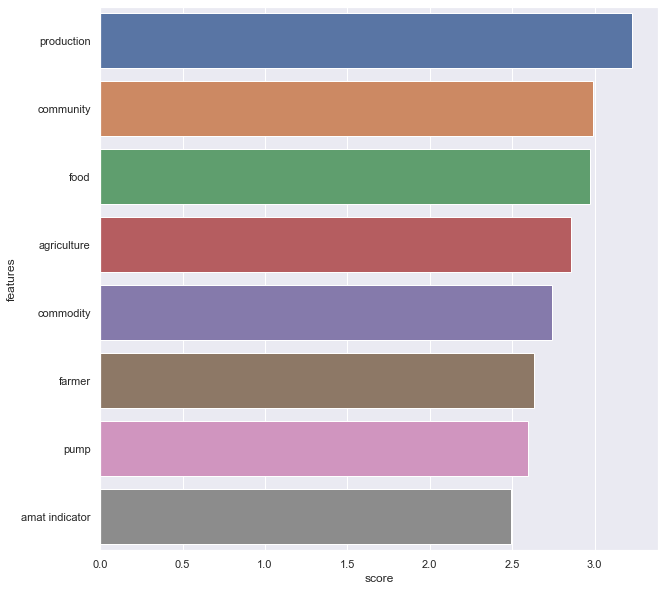

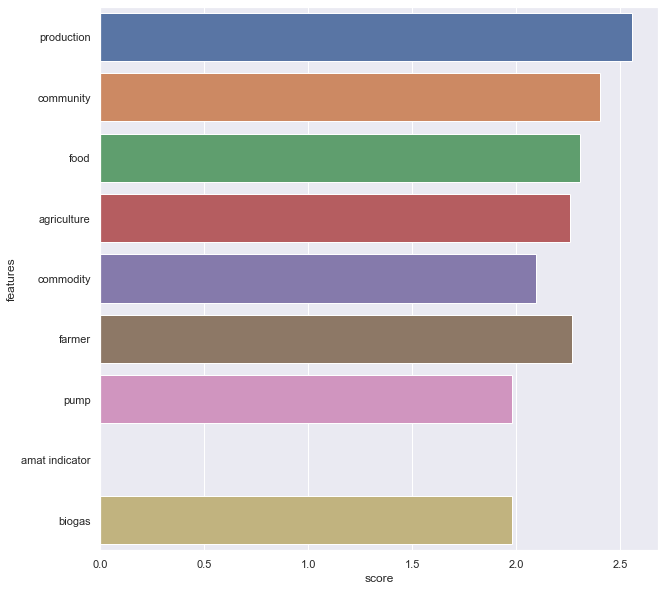

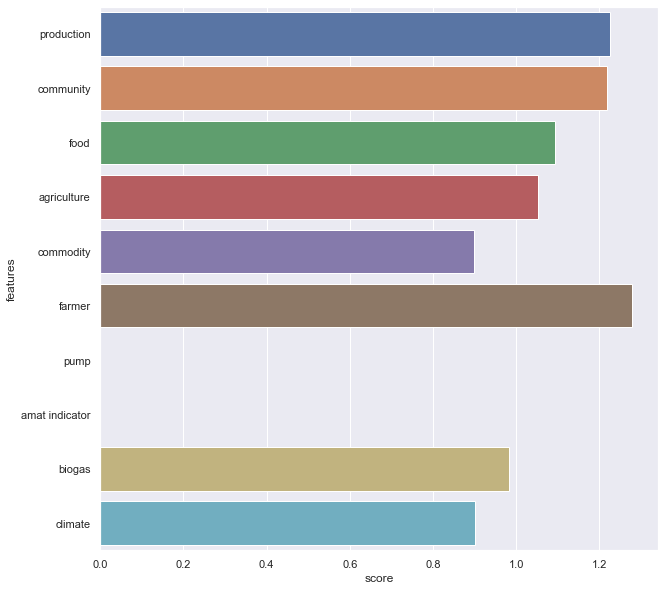

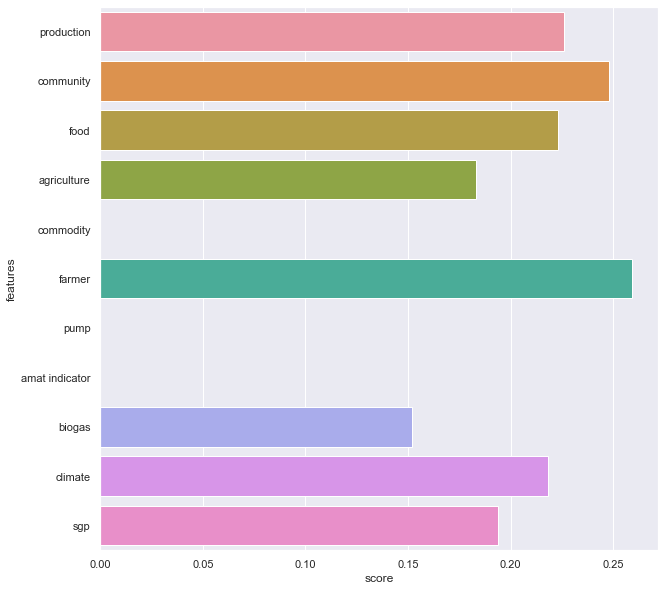

In [19]:
df_regressors = pd.DataFrame(columns = ["label", "features", "score"])


X_train, X_test, y_train, y_test = train_test_split(df_trunc['all_text_clean_spacy'],
                                                    df_trunc['food_and_agricultural_commodities'].values,
                                                    test_size = .3,
                                                    random_state = 1,
                                                    shuffle = True)
print('train size:', len(X_train))
print('test size:', len(X_test))

assert len(set(y_train)) == len(set(y_test)), "Unequal splits with some labels missing"

'''extract features using tfidf vecorization:'''
vectorizer = TfidfVectorizer(ngram_range = (1,2),min_df = 0.01, max_df = 0.95)


vect = vectorizer.fit(X_train)
X_train = vect.transform(X_train)
X_test = vect.transform(X_test)




#add additional feature weight
"""
vect = vectorizer.fit(X_train)
query_vec = vect.transform(X_train)

weight = 10

position = vect.vocabulary_['ews']
query_vec[:, position] *= weight

position = vect.vocabulary_['early warning']
query_vec[:, position] *= weight
"""


C = [10, 5, 1, 0.1]

for c in C:
    print('C equals:', c)
    clf = LogisticRegression(penalty='l2', solver = 'lbfgs', class_weight= 'balanced', C = c).fit(X_train, y_train)
    print('')
    print('Training accuracy:', clf.score(X_train, y_train).round(3))
    print('Test accuracy:', clf.score(X_test, y_test).round(3))
    y_hat = clf.predict(X_test)
    print('f1 score:', f1_score(y_test, y_hat, average="macro"))

    #top regressors 
    #return top  regressors and convert to dataframe for visualisation:
    df_lambda = tools.get_topwords(clf, vectorizer, n = 8, n_models = 1, show_idxmax = True)
    keywords = df_lambda.Keywords.iloc[0]

    for key in keywords:

        df_regressors = df_regressors.append({'label': 'Food_and_Agricultural_Commodities', "features":key}, ignore_index=True)
        df_regressors['features'] = df_regressors['features'].astype(str)
        df_regressors['features'] = df_regressors['features'].str.replace('(','')
        df_regressors['features'] = df_regressors['features'].str.replace(')','')
        df_regressors['features'] = df_regressors['features'].str.replace("'",'')               


    df_regressors[['features','score']] = df_regressors['features'].str.split(',',expand=True)
    df_regressors['score'] = df_regressors['score'].astype(float)    
    plt.figure(figsize=(10,10))
    sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = df_regressors)